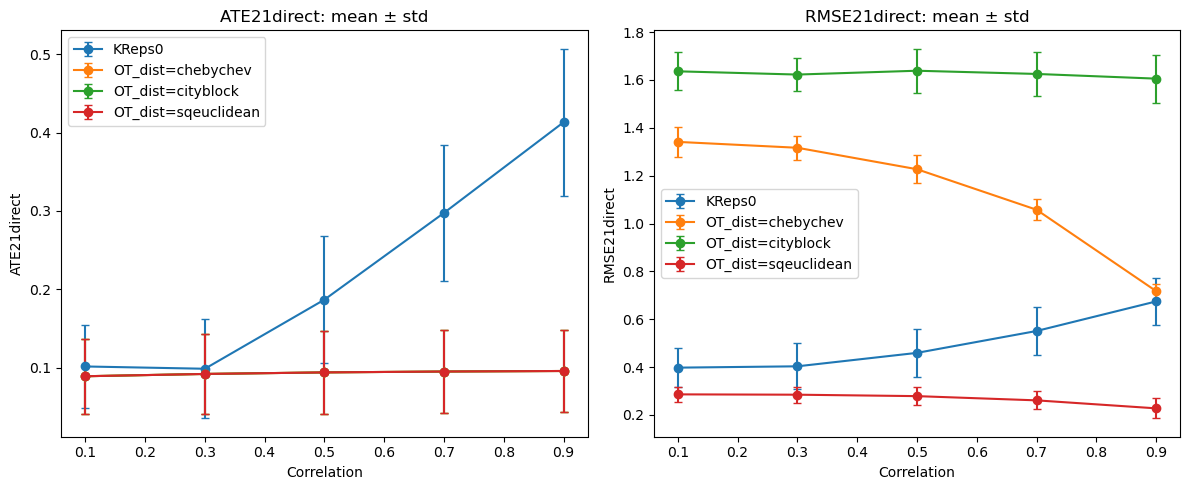

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Replace this with your actual loaded results list
results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=True_multivariate=True.pt')
#results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=False_multivariate=False.pt')
df = pd.DataFrame(results)

# Group by model name and correlation
grouped = df.groupby(['name', 'corr']).agg({
    'ATE21direct': ['mean', 'std'],
    'RMSE21direct': ['mean', 'std']
}).reset_index()

# Flatten MultiIndex columns
grouped.columns = ['name', 'corr',
                   'ATE21direct_mean', 'ATE21direct_std',
                   'RMSE21direct_mean', 'RMSE21direct_std']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for model in grouped['name'].unique():
    subset = grouped[grouped['name'] == model]
    axes[0].errorbar(subset['corr'], subset['ATE21direct_mean'],
                     yerr=subset['ATE21direct_std'], label=model, capsize=3, marker='o')
    axes[1].errorbar(subset['corr'], subset['RMSE21direct_mean'],
                     yerr=subset['RMSE21direct_std'], label=model, capsize=3, marker='o')

axes[0].set_title('ATE21direct: mean ± std')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('ATE21direct')
axes[0].legend()

axes[1].set_title('RMSE21direct: mean ± std')
axes[1].set_xlabel('Correlation')
axes[1].set_ylabel('RMSE21direct')
axes[1].legend()

plt.tight_layout()
plt.show()


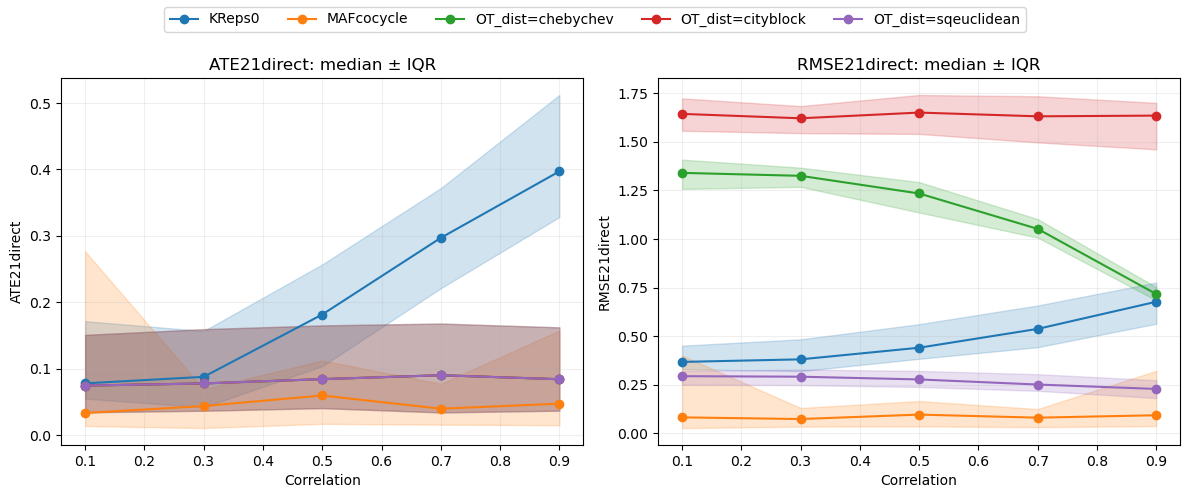

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_ate_rmse_bands(results, results_cocycle=None, use_median_iqr=True, alpha=0.05):
    """
    Plot ATE21direct and RMSE21direct across corr for each model name.

    Band can be:
      - median + interquartile range (use_median_iqr=True)
      - mean ± std (use_median_iqr=False and alpha=None)
      - [alpha, 1-alpha] quantiles (use_median_iqr=False and alpha set)
    """
    # Base results
    df_base = pd.DataFrame(results)
    
    # Optional cocycle results mapping
    if results_cocycle is not None:
        if not isinstance(results_cocycle, list):
            results_cocycle = [results_cocycle]
        df_cocycle = pd.DataFrame(results_cocycle).copy()
        df_cocycle = df_cocycle.rename(columns={
            'ATE21': 'ATE21direct',
            'RMSE21': 'RMSE21direct'
        })
        df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
    else:
        df_all = df_base
    
    df_all = df_all.sort_values('corr')

    # Grouped stats
    grouped = df_all.groupby(['name', 'corr']).agg(
        ATE_mean=('ATE21direct', 'mean'),
        ATE_std=('ATE21direct', 'std'),
        ATE_median=('ATE21direct', 'median'),
        ATE_q25=('ATE21direct', lambda s: s.quantile(alpha)),
        ATE_q75=('ATE21direct', lambda s: s.quantile(1-alpha)),
        ATE_qlo=('ATE21direct', lambda s: s.quantile(alpha)),
        ATE_qhi=('ATE21direct', lambda s: s.quantile(1-alpha)),
        
        RMSE_mean=('RMSE21direct', 'mean'),
        RMSE_std=('RMSE21direct', 'std'),
        RMSE_median=('RMSE21direct', 'median'),
        RMSE_q25=('RMSE21direct', lambda s: s.quantile(alpha)),
        RMSE_q75=('RMSE21direct', lambda s: s.quantile(1-alpha)),
        RMSE_qlo=('RMSE21direct', lambda s: s.quantile(alpha)),
        RMSE_qhi=('RMSE21direct', lambda s: s.quantile(1-alpha)),
    ).reset_index()

    grouped[['ATE_std', 'RMSE_std']] = grouped[['ATE_std', 'RMSE_std']].fillna(0.0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    colors = {}

    for model in grouped['name'].unique():
        sub = grouped[grouped['name'] == model].sort_values('corr')
        x = sub['corr'].values

        if use_median_iqr:
            y_line = sub['ATE_median'].values
            y_lo = sub['ATE_q25'].values
            y_hi = sub['ATE_q75'].values
            band_label = 'median ± IQR'
        elif alpha is not None:
            y_line = sub['ATE_mean'].values
            y_lo = sub['ATE_qlo'].values
            y_hi = sub['ATE_qhi'].values
            band_label = f'quantile band [{alpha:.2f}, {1-alpha:.2f}]'
        else:
            y_line = sub['ATE_mean'].values
            y_lo = sub['ATE_mean'].values - sub['ATE_std'].values
            y_hi = sub['ATE_mean'].values + sub['ATE_std'].values
            band_label = 'mean ± std'

        (l1,) = axes[0].plot(x, y_line, marker='o', label=model)
        if model not in colors:
            colors[model] = l1.get_color()
        c = colors[model]
        axes[0].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

        if use_median_iqr:
            y_line = sub['RMSE_median'].values
            y_lo = sub['RMSE_q25'].values
            y_hi = sub['RMSE_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_qlo'].values
            y_hi = sub['RMSE_qhi'].values
        else:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_mean'].values - sub['RMSE_std'].values
            y_hi = sub['RMSE_mean'].values + sub['RMSE_std'].values

        axes[1].plot(x, y_line, marker='o', label=model, color=c)
        axes[1].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

    axes[0].set_title(f'ATE21direct: {band_label}')
    axes[1].set_title(f'RMSE21direct: {band_label}')
    for ax in axes:
        ax.set_xlabel('Correlation')
        ax.grid(True, alpha=0.2)
    axes[0].set_ylabel('ATE21direct')
    axes[1].set_ylabel('RMSE21direct')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=min(5, len(labels)))
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# Example:
results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=True_multivariate=True.pt')
results_cocycle = torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=True_lr=0.01_new.pt')
plot_ate_rmse_bands(results, results_cocycle, use_median_iqr=True, alpha = 0.1)

/tmp/ipykernel_644654/563261621.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(trim_group)


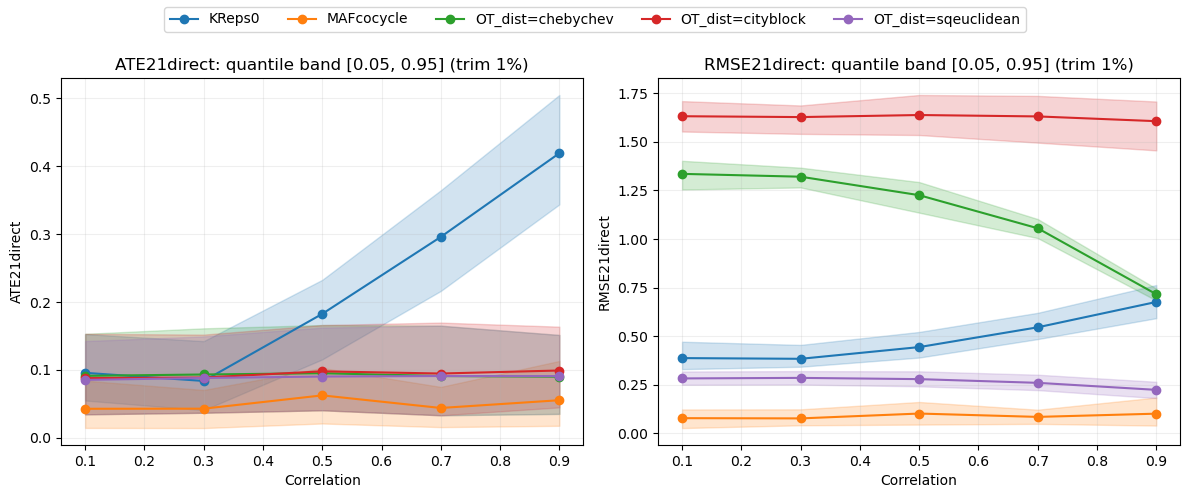

In [60]:
def plot_ate_rmse_bands_trimmed(results, results_cocycle=None, use_median_iqr=True,
                                alpha=0.05, trim_frac=0.05):
    df_base = pd.DataFrame(results)

    if results_cocycle is not None:
        if not isinstance(results_cocycle, list):
            results_cocycle = [results_cocycle]
        df_cocycle = pd.DataFrame(results_cocycle).copy()
        df_cocycle = df_cocycle.rename(columns={
            'ATE21': 'ATE21direct',
            'RMSE21': 'RMSE21direct'
        })
        df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
    else:
        df_all = df_base

    df_all = df_all.sort_values('corr')

    def trim_group(g):
        g = g.copy()
        for col in ['ATE21direct', 'RMSE21direct']:
            lo = g[col].quantile(trim_frac)
            hi = g[col].quantile(1 - trim_frac)
            g = g[(g[col] >= lo) & (g[col] <= hi)]
        return g

    trimmed = (
        df_all.groupby(['name', 'corr'], group_keys=False)
              .apply(trim_group)
              .reset_index(drop=True)
    )

    grouped = trimmed.groupby(['name', 'corr']).agg(
        ATE_mean=('ATE21direct', 'mean'),
        ATE_std=('ATE21direct', 'std'),
        ATE_median=('ATE21direct', 'median'),
        ATE_q25=('ATE21direct', lambda s: s.quantile(0.25)),
        ATE_q75=('ATE21direct', lambda s: s.quantile(0.75)),
        ATE_qlo=('ATE21direct', lambda s: s.quantile(alpha)),
        ATE_qhi=('ATE21direct', lambda s: s.quantile(1 - alpha)),

        RMSE_mean=('RMSE21direct', 'mean'),
        RMSE_std=('RMSE21direct', 'std'),
        RMSE_median=('RMSE21direct', 'median'),
        RMSE_q25=('RMSE21direct', lambda s: s.quantile(0.25)),
        RMSE_q75=('RMSE21direct', lambda s: s.quantile(0.75)),
        RMSE_qlo=('RMSE21direct', lambda s: s.quantile(alpha)),
        RMSE_qhi=('RMSE21direct', lambda s: s.quantile(1 - alpha)),
    ).reset_index()

    grouped[['ATE_std', 'RMSE_std']] = grouped[['ATE_std', 'RMSE_std']].fillna(0.0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    colors = {}

    for model in grouped['name'].unique():
        sub = grouped[grouped['name'] == model].sort_values('corr')
        x = sub['corr'].values

        if use_median_iqr:
            y_line = sub['ATE_median'].values
            y_lo = sub['ATE_q25'].values
            y_hi = sub['ATE_q75'].values
            band_label = f'median ± IQR (trim {trim_frac*100:.0f}%)'
        elif alpha is not None:
            y_line = sub['ATE_mean'].values
            y_lo = sub['ATE_qlo'].values
            y_hi = sub['ATE_qhi'].values
            band_label = f'quantile band [{alpha:.2f}, {1-alpha:.2f}] (trim {trim_frac*100:.0f}%)'
        else:
            y_line = sub['ATE_mean'].values
            y_lo = sub['ATE_mean'].values - sub['ATE_std'].values
            y_hi = sub['ATE_mean'].values + sub['ATE_std'].values
            band_label = f'mean ± std (trim {trim_frac*100:.0f}%)'

        (l1,) = axes[0].plot(x, y_line, marker='o', label=model)
        if model not in colors:
            colors[model] = l1.get_color()
        c = colors[model]
        axes[0].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

        if use_median_iqr:
            y_line = sub['RMSE_median'].values
            y_lo = sub['RMSE_q25'].values
            y_hi = sub['RMSE_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_qlo'].values
            y_hi = sub['RMSE_qhi'].values
        else:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_mean'].values - sub['RMSE_std'].values
            y_hi = sub['RMSE_mean'].values + sub['RMSE_std'].values

        axes[1].plot(x, y_line, marker='o', label=model, color=c)
        axes[1].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

    axes[0].set_title(f'ATE21direct: {band_label}')
    axes[1].set_title(f'RMSE21direct: {band_label}')
    for ax in axes:
        ax.set_xlabel('Correlation')
        ax.grid(True, alpha=0.2)
    axes[0].set_ylabel('ATE21direct')
    axes[1].set_ylabel('RMSE21direct')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=min(5, len(labels)))
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


# Example:
results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=True_multivariate=True.pt')
results_cocycle = torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=True_lr=0.01_new.pt')
plot_ate_rmse_bands_trimmed(results, results_cocycle, use_median_iqr=False, alpha = 0.05, trim_frac = 0.01)

/tmp/ipykernel_644654/1226892040.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_base = df_base['name'].str.contains(r'(KReps|sqeuclidean)', flags=re.IGNORECASE, regex=True)
/tmp/ipykernel_644654/1226892040.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(trim_group)


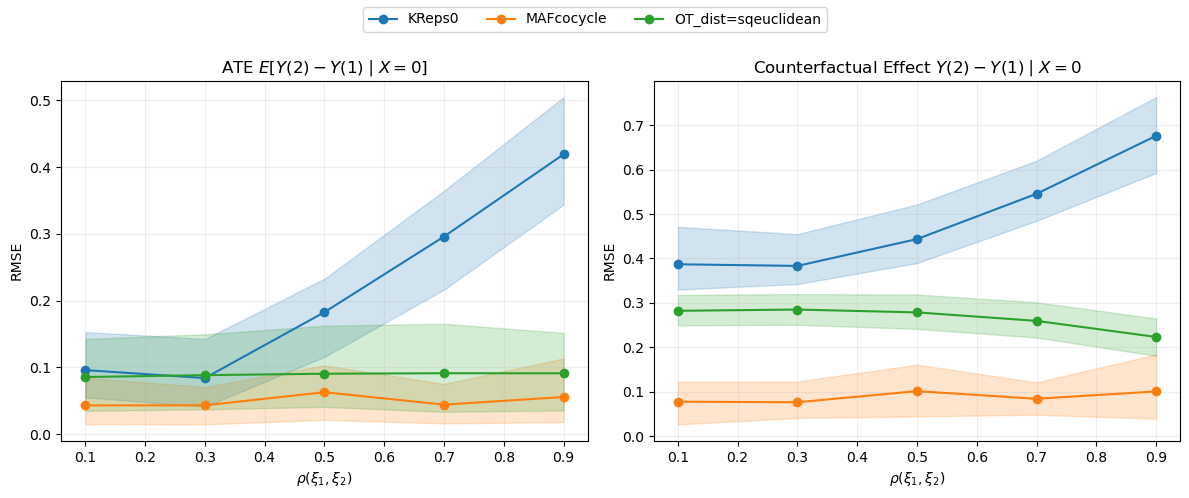

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re

def plot_ate_rmse_bands_trimmed_kr_sqeuclidean_cocycles(
        results, results_cocycle=None,
        use_median_iqr=True, alpha=0.05, trim_frac=0.05):
    """
    Plot ONLY:
      - KR results (name contains 'KReps', case-insensitive)
      - squared-Euclidean OT results (name contains 'sqeuclidean', case-insensitive)
      - cocycle results (appended; ATE21->ATE21direct, RMSE21->RMSE21direct)

    Panels:
      LHS: ATE21direct
      RHS: RMSE21direct

    Trimming:
      For each (name, corr) group, trims top/bottom `trim_frac` fraction
      for each metric separately BEFORE aggregation.

    Bands:
      - use_median_iqr=True  -> median line, shaded IQR (25–75%)
      - use_median_iqr=False & alpha is not None -> mean line, shaded [alpha, 1-alpha]
      - use_median_iqr=False & alpha is None     -> mean line, shaded mean ± std
    """
    # --- Base results: keep only KR + squared-euclidean OT ---
    df_base = pd.DataFrame(results)
    mask_base = df_base['name'].str.contains(r'(KReps|sqeuclidean)', flags=re.IGNORECASE, regex=True)
    df_base = df_base[mask_base].copy()

    # --- Append cocycle results (rename metrics to align) ---
    if results_cocycle is not None:
        if not isinstance(results_cocycle, list):
            results_cocycle = [results_cocycle]
        df_cocycle = pd.DataFrame(results_cocycle).copy()
        df_cocycle = df_cocycle.rename(columns={'ATE21': 'ATE21direct', 'RMSE21': 'RMSE21direct'})
        df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
    else:
        df_all = df_base.copy()

    # Ensure required columns exist
    for col in ['ATE21direct', 'RMSE21direct', 'name', 'corr']:
        if col not in df_all.columns:
            raise KeyError(f"Missing required column '{col}' in combined results.")

    df_all = df_all.sort_values('corr')

    # --- Trim per (name, corr) and per metric ---
    def trim_group(g):
        g = g.copy()
        for col in ['ATE21direct', 'RMSE21direct']:
            lo = g[col].quantile(trim_frac)
            hi = g[col].quantile(1 - trim_frac)
            g = g[(g[col] >= lo) & (g[col] <= hi)]
        return g

    trimmed = (
        df_all.groupby(['name', 'corr'], group_keys=False)
              .apply(trim_group)
              .reset_index(drop=True)
    )

    # --- Aggregate stats ---
    grouped = trimmed.groupby(['name', 'corr']).agg(
        # ATE
        ATE_mean=('ATE21direct', 'mean'),
        ATE_std=('ATE21direct', 'std'),
        ATE_median=('ATE21direct', 'median'),
        ATE_q25=('ATE21direct', lambda s: s.quantile(0.25)),
        ATE_q75=('ATE21direct', lambda s: s.quantile(0.75)),
        ATE_qlo=('ATE21direct', lambda s: s.quantile(alpha)),
        ATE_qhi=('ATE21direct', lambda s: s.quantile(1 - alpha)),
        # RMSE
        RMSE_mean=('RMSE21direct', 'mean'),
        RMSE_std=('RMSE21direct', 'std'),
        RMSE_median=('RMSE21direct', 'median'),
        RMSE_q25=('RMSE21direct', lambda s: s.quantile(0.25)),
        RMSE_q75=('RMSE21direct', lambda s: s.quantile(0.75)),
        RMSE_qlo=('RMSE21direct', lambda s: s.quantile(alpha)),
        RMSE_qhi=('RMSE21direct', lambda s: s.quantile(1 - alpha)),
    ).reset_index()

    grouped[['ATE_std', 'RMSE_std']] = grouped[['ATE_std', 'RMSE_std']].fillna(0.0)

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    colors = {}

    if use_median_iqr:
        band_label = f'median ± IQR (trim {trim_frac*100:.0f}%)'
    elif alpha is not None:
        band_label = f'mean line, quantile band [{alpha:.2f}, {1-alpha:.2f}] (trim {trim_frac*100:.0f}%)'
    else:
        band_label = f'mean ± std (trim {trim_frac*100:.0f}%)'

    for model in grouped['name'].unique():
        sub = grouped[grouped['name'] == model].sort_values('corr')
        x = sub['corr'].values

        # ----- Left: ATE -----
        if use_median_iqr:
            y_line = sub['ATE_median'].values
            y_lo = sub['ATE_q25'].values
            y_hi = sub['ATE_q75'].values
        elif alpha is not None:
            y_line = sub['ATE_mean'].values
            y_lo = sub['ATE_qlo'].values
            y_hi = sub['ATE_qhi'].values
        else:
            y_line = sub['ATE_mean'].values
            y_lo = y_line - sub['ATE_std'].values
            y_hi = y_line + sub['ATE_std'].values

        (l1,) = axes[0].plot(x, y_line, marker='o', label=model)
        if model not in colors:
            colors[model] = l1.get_color()
        c = colors[model]
        axes[0].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

        # ----- Right: RMSE -----
        if use_median_iqr:
            y_line = sub['RMSE_median'].values
            y_lo = sub['RMSE_q25'].values
            y_hi = sub['RMSE_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_qlo'].values
            y_hi = sub['RMSE_qhi'].values
        else:
            y_line = sub['RMSE_mean'].values
            y_lo = y_line - sub['RMSE_std'].values
            y_hi = y_line + sub['RMSE_std'].values

        axes[1].plot(x, y_line, marker='o', label=model, color=c)
        axes[1].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

    axes[0].set_title(r'ATE $E[Y(2) - Y(1) \mid X=0]$')
    axes[1].set_title(r'Counterfactual Effect $Y(2) - Y(1) \mid  X=0$')
    for ax in axes:
        ax.set_xlabel(r'$\rho(\xi_1,\xi_2)$')
        ax.grid(True, alpha=0.2)
    axes[0].set_ylabel('RMSE')
    axes[1].set_ylabel('RMSE')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=min(6, len(labels)))
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# Example:
results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=True_multivariate=True.pt')
results_cocycle = torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=True_lr=0.01_new.pt')
plot_ate_rmse_bands_trimmed_kr_sqeuclidean_cocycles(results, results_cocycle, use_median_iqr=False, trim_frac = 0.01)

/tmp/ipykernel_843769/1367781797.py:38: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_base = df_base['name'].str.contains(
/tmp/ipykernel_843769/1367781797.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(trim_group)


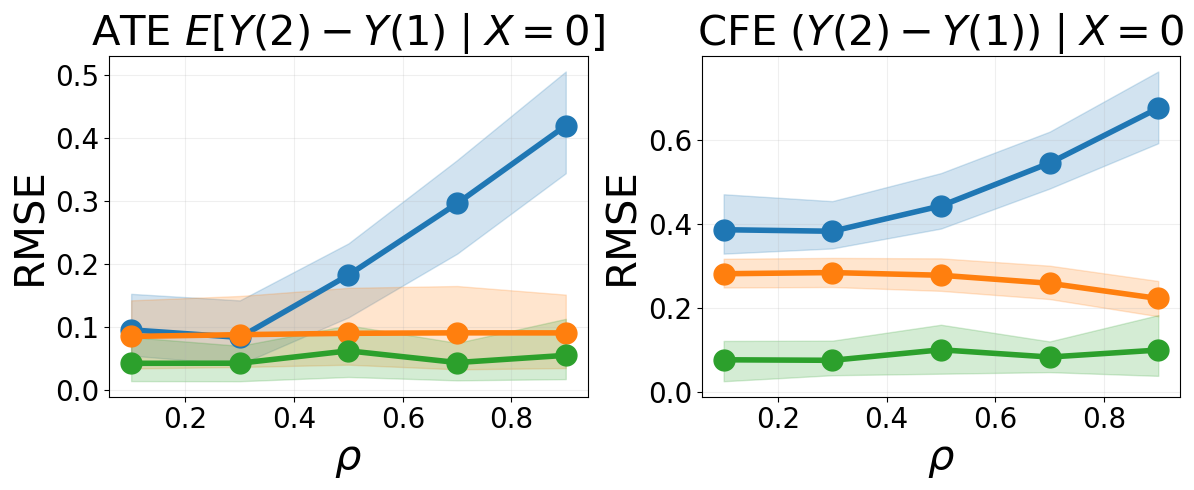

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re

def plot_ate_rmse_bands_trimmed_kr_sqeuclidean_cocycles(
        results, results_cocycle=None,
        use_median_iqr=True, alpha=0.05, trim_frac=0.05,
        # NEW: legend + style controls
        name_map=None,                 # dict: {"KReps0":"KR (ours)", "OTsqeuclidean":"OT L2", "MAFcocycle":"MAF Cocycle"}
        legend_inside=False,           # place legend inside a subplot (True) or above figure (False)
        legend_ax_index=1,             # which subplot to put legend in if legend_inside=True (0 or 1)
        legend_loc='lower right',      # legend location if inside
        legend_ncol=None,              # legend column count (auto if None)
        # NEW: font scaling
        base_fontsize=10,              # base fontsize
        title_scale=1.0, label_scale=1.0, tick_scale=1.0, legend_scale=1.0,
        # Optional regex patterns (edit if your names differ)
        kr_pattern=r'KReps', sqeuclid_pattern=r'sqeuclidean',
        maf_cocycle_pattern=r'(maf.*cocycle|cocycle.*maf|mafcocycle)'
    ):
    """
    Plot ONLY:
      - KR results (name contains kr_pattern)
      - squared-Euclidean OT results (name contains sqeuclid_pattern)
      - cocycle results (appended; ATE21->ATE21direct, RMSE21->RMSE21direct)

    Panels: left=ATE21direct, right=RMSE21direct
    Trimming: per (name, corr) & per metric by 'trim_frac' at both tails.
    Bands:
      - use_median_iqr=True         -> median line, 25–75% band
      - use_median_iqr=False, alpha -> mean line, [alpha, 1-alpha] band
      - use_median_iqr=False, None  -> mean line, ± std band
    """
    # --- Base results: keep only KR + squared-euclidean OT ---
    df_base = pd.DataFrame(results)
    mask_base = df_base['name'].str.contains(
        rf'({kr_pattern}|{sqeuclid_pattern})', flags=re.IGNORECASE, regex=True
    )
    df_base = df_base[mask_base].copy()

    # --- Append cocycle results (rename metrics to align) ---
    if results_cocycle is not None:
        if not isinstance(results_cocycle, list):
            results_cocycle = [results_cocycle]
        df_cocycle = pd.DataFrame(results_cocycle).copy()
        df_cocycle = df_cocycle.rename(columns={'ATE21': 'ATE21direct', 'RMSE21': 'RMSE21direct'})
        df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
    else:
        df_all = df_base.copy()

    # Ensure required columns exist
    for col in ['ATE21direct', 'RMSE21direct', 'name', 'corr']:
        if col not in df_all.columns:
            raise KeyError(f"Missing required column '{col}' in combined results.")

    df_all = df_all.sort_values('corr')

    # --- Trim per (name, corr) and per metric ---
    def trim_group(g):
        g = g.copy()
        for col in ['ATE21direct', 'RMSE21direct']:
            lo = g[col].quantile(trim_frac)
            hi = g[col].quantile(1 - trim_frac)
            g = g[(g[col] >= lo) & (g[col] <= hi)]
        return g

    trimmed = (
        df_all.groupby(['name', 'corr'], group_keys=False)
              .apply(trim_group)
              .reset_index(drop=True)
    )

    # --- Aggregate stats ---
    grouped = trimmed.groupby(['name', 'corr']).agg(
        # ATE
        ATE_mean=('ATE21direct', 'mean'),
        ATE_std=('ATE21direct', 'std'),
        ATE_median=('ATE21direct', 'median'),
        ATE_q25=('ATE21direct', lambda s: s.quantile(0.25)),
        ATE_q75=('ATE21direct', lambda s: s.quantile(0.75)),
        ATE_qlo=('ATE21direct', lambda s: s.quantile(alpha)),
        ATE_qhi=('ATE21direct', lambda s: s.quantile(1 - alpha)),
        # RMSE
        RMSE_mean=('RMSE21direct', 'mean'),
        RMSE_std=('RMSE21direct', 'std'),
        RMSE_median=('RMSE21direct', 'median'),
        RMSE_q25=('RMSE21direct', lambda s: s.quantile(0.25)),
        RMSE_q75=('RMSE21direct', lambda s: s.quantile(0.75)),
        RMSE_qlo=('RMSE21direct', lambda s: s.quantile(alpha)),
        RMSE_qhi=('RMSE21direct', lambda s: s.quantile(1 - alpha)),
    ).reset_index()

    grouped[['ATE_std', 'RMSE_std']] = grouped[['ATE_std', 'RMSE_std']].fillna(0.0)

    # --- Order models: put MAF cocycle last ---
    def is_maf_cocycle(name: str) -> bool:
        return bool(re.search(maf_cocycle_pattern, name, flags=re.IGNORECASE)) or 'cocycle' in name.lower()

    model_order = sorted(grouped['name'].unique(),
                         key=lambda n: (is_maf_cocycle(n), n.lower()))
    # (others first; MAF-cocycle True -> sorted to the end)

    # --- Font sizes ---
    plt.rcParams.update({
        'axes.titlesize': base_fontsize * title_scale,
        'axes.labelsize': base_fontsize * label_scale,
        'xtick.labelsize': base_fontsize * tick_scale,
        'ytick.labelsize': base_fontsize * tick_scale,
    })
    legend_fs = base_fontsize * legend_scale

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    colors = {}

    if use_median_iqr:
        band_label = f'median ± IQR (trim {trim_frac*100:.0f}%)'
    elif alpha is not None:
        band_label = f'mean line, quantile band [{alpha:.2f}, {1-alpha:.2f}] (trim {trim_frac*100:.0f}%)'
    else:
        band_label = f'mean ± std (trim {trim_frac*100:.0f}%)'

    for model in model_order:
        sub = grouped[grouped['name'] == model].sort_values('corr')
        x = sub['corr'].values

        # ----- Left: ATE -----
        if use_median_iqr:
            y_line = sub['ATE_median'].values
            y_lo = sub['ATE_q25'].values
            y_hi = sub['ATE_q75'].values
        elif alpha is not None:
            y_line = sub['ATE_mean'].values
            y_lo = sub['ATE_qlo'].values
            y_hi = sub['ATE_qhi'].values
        else:
            y_line = sub['ATE_mean'].values
            y_lo = y_line - sub['ATE_std'].values
            y_hi = y_line + sub['ATE_std'].values

        (l1,) = axes[0].plot(x, y_line, marker='o',
                             label=name_map.get(model, model) if name_map else model, markersize = 15, lw = 4)
        if model not in colors:
            colors[model] = l1.get_color()
        c = colors[model]
        axes[0].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

        # ----- Right: RMSE -----
        if use_median_iqr:
            y_line = sub['RMSE_median'].values
            y_lo = sub['RMSE_q25'].values
            y_hi = sub['RMSE_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_qlo'].values
            y_hi = sub['RMSE_qhi'].values
        else:
            y_line = sub['RMSE_mean'].values
            y_lo = y_line - sub['RMSE_std'].values
            y_hi = y_line + sub['RMSE_std'].values

        axes[1].plot(x, y_line, marker='o',
                     label=name_map.get(model, model) if name_map else model, color=c, markersize = 15, lw = 4)
        axes[1].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

    # Titles / labels
    axes[0].set_title(r'ATE $E[Y(2) - Y(1) \mid X=0]$')
    axes[1].set_title(r'CFE $(Y(2) - Y(1)) \mid  X=0$')
    for ax in axes:
        ax.set_xlabel(r'$\rho$')
        ax.grid(True, alpha=0.2)
    axes[0].set_ylabel('RMSE')
    axes[1].set_ylabel('RMSE')

    # Legend: inside a subplot or above figure
    if legend_inside:
        axL = axes[legend_ax_index]
        handles, labels = axL.get_legend_handles_labels()
        if legend_ncol is None:
            legend_ncol = min(6, len(labels))
        #axL.legend(handles, labels, loc=legend_loc, fontsize=legend_fs,
        #           framealpha=0.9, ncol=legend_ncol)
    else:
        handles, labels = axes[0].get_legend_handles_labels()
        if legend_ncol is None:
            legend_ncol = min(6, len(labels))
        fig.legend(handles, labels, loc='upper center', ncol=legend_ncol, fontsize=legend_fs)

    plt.tight_layout(rect=[0, 0, 1, 0.90] if not legend_inside else None)
    plt.savefig("OT_results_corr_effect.png", bbox_inches = "tight")
    plt.show()

# Example:
results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=True_multivariate=True.pt')
results_cocycle = torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=True_lr=0.01_new.pt')
name_map = {
    'KReps0': 'Seq-OT (KR)',
    'OT_dist=sqeuclidean': 'OT (L2)',
    'MAFcocycle': 'Cocycle (MAF)',
}
plot_ate_rmse_bands_trimmed_kr_sqeuclidean_cocycles(results, results_cocycle, use_median_iqr=False, trim_frac = 0.01, legend_inside = True,
                                                   title_scale=3.0, label_scale=3.0, tick_scale=2.0, legend_scale=1.5, name_map = name_map,
                                                   legend_ncol = 1)

/tmp/ipykernel_644654/1212875487.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(trim_group)


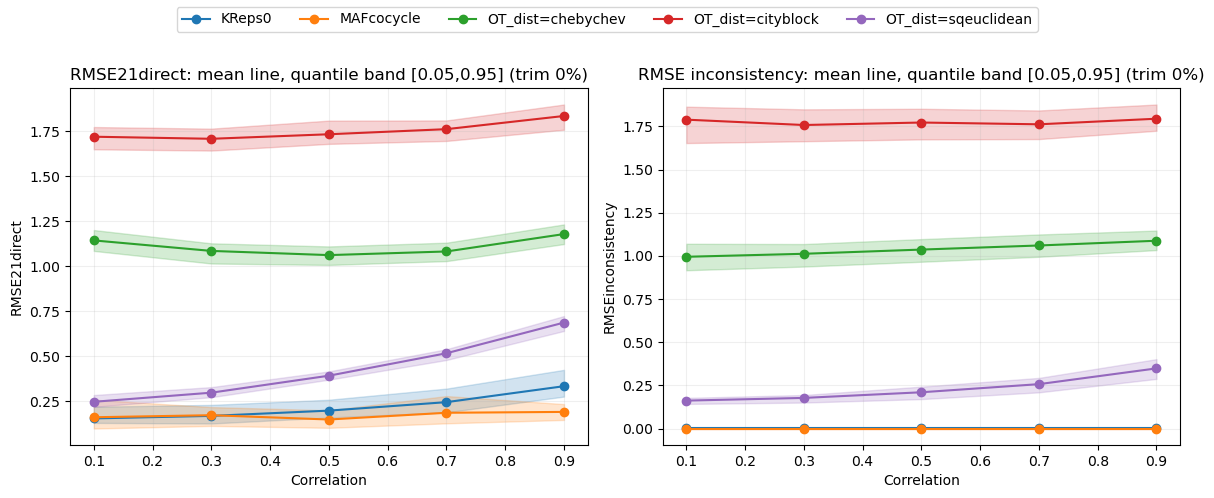

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_rmse_and_inconsistency(results,
                                results_cocycle=None,
                                use_median_iqr=True,
                                alpha=0.05,
                                trim_frac=0.05):
    """
    Plots:
      LHS: RMSE21direct
      RHS: RMSEinconsistency (cocycle results are set to 0)

    Trims top/bottom `trim_frac` fraction per (name, corr) group BEFORE aggregation
    for *each* metric separately.

    Bands:
      - use_median_iqr=True  -> median line, shaded IQR (25–75%)
      - use_median_iqr=False & alpha is not None -> mean line, shaded [alpha, 1-alpha] band
      - use_median_iqr=False & alpha is None     -> mean line, shaded mean ± std
    """
    # Base results
    df_base = pd.DataFrame(results)

    # Map cocycle results to the same schema if provided
    if results_cocycle is not None:
        if not isinstance(results_cocycle, list):
            results_cocycle = [results_cocycle]
        df_cocycle = pd.DataFrame(results_cocycle).copy()
        # Align column names used downstream
        df_cocycle = df_cocycle.rename(columns={
            'ATE21': 'ATE21direct',
            'RMSE21': 'RMSE21direct'
        })
        # Cocycle inconsistency is defined as 0 (no entries provided)
        df_cocycle['RMSEinconsistency'] = 0.0
        df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
    else:
        df_all = df_base.copy()

    # If OT results lacked these exact names, ensure presence
    # (RMSE21direct should already exist in OT results; if not, you can adapt here)
    if 'RMSEinconsistency' not in df_all.columns:
        df_all['RMSEinconsistency'] = np.nan  # should not happen if OT results contain it

    df_all = df_all.sort_values('corr')

    # --- Trimming helpers ---
    def trim_group(g):
        g = g.copy()
        # Trim each metric separately
        for col in ['RMSE21direct', 'RMSEinconsistency']:
            if col in g:
                lo = g[col].quantile(trim_frac)
                hi = g[col].quantile(1 - trim_frac)
                g = g[(g[col] >= lo) & (g[col] <= hi)]
        return g

    trimmed = (
        df_all.groupby(['name', 'corr'], group_keys=False)
              .apply(trim_group)
              .reset_index(drop=True)
    )

    # --- Aggregate stats for plotting ---
    grouped = trimmed.groupby(['name', 'corr']).agg(
        # RMSE
        RMSE_mean=('RMSE21direct', 'mean'),
        RMSE_std =('RMSE21direct', 'std'),
        RMSE_median=('RMSE21direct', 'median'),
        RMSE_q25=('RMSE21direct', lambda s: s.quantile(0.25)),
        RMSE_q75=('RMSE21direct', lambda s: s.quantile(0.75)),
        RMSE_qlo=('RMSE21direct', lambda s: s.quantile(alpha)),
        RMSE_qhi=('RMSE21direct', lambda s: s.quantile(1 - alpha)),
        # Inconsistency
        INC_mean=('RMSEinconsistency', 'mean'),
        INC_std =('RMSEinconsistency', 'std'),
        INC_median=('RMSEinconsistency', 'median'),
        INC_q25=('RMSEinconsistency', lambda s: s.quantile(0.25)),
        INC_q75=('RMSEinconsistency', lambda s: s.quantile(0.75)),
        INC_qlo=('RMSEinconsistency', lambda s: s.quantile(alpha)),
        INC_qhi=('RMSEinconsistency', lambda s: s.quantile(1 - alpha)),
    ).reset_index()

    grouped[['RMSE_std', 'INC_std']] = grouped[['RMSE_std', 'INC_std']].fillna(0.0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    colors = {}

    # Pick the description for the band for titles
    if use_median_iqr:
        band_desc = f'median ± IQR (trim {trim_frac*100:.0f}%)'
    elif alpha is not None:
        band_desc = f'mean line, quantile band [{alpha:.2f},{1-alpha:.2f}] (trim {trim_frac*100:.0f}%)'
    else:
        band_desc = f'mean ± std (trim {trim_frac*100:.0f}%)'

    for model in grouped['name'].unique():
        sub = grouped[grouped['name'] == model].sort_values('corr')
        x = sub['corr'].values

        # ----- Left panel: RMSE -----
        if use_median_iqr:
            y_line = sub['RMSE_median'].values
            y_lo = sub['RMSE_q25'].values
            y_hi = sub['RMSE_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_qlo'].values
            y_hi = sub['RMSE_qhi'].values
        else:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_mean'].values - sub['RMSE_std'].values
            y_hi = sub['RMSE_mean'].values + sub['RMSE_std'].values

        (l1,) = axes[0].plot(x, y_line, marker='o', label=model)
        if model not in colors:
            colors[model] = l1.get_color()
        c = colors[model]
        axes[0].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

        # ----- Right panel: Inconsistency -----
        if use_median_iqr:
            y_line = sub['INC_median'].values
            y_lo = sub['INC_q25'].values
            y_hi = sub['INC_q75'].values
        elif alpha is not None:
            y_line = sub['INC_mean'].values
            y_lo = sub['INC_qlo'].values
            y_hi = sub['INC_qhi'].values
        else:
            y_line = sub['INC_mean'].values
            y_lo = sub['INC_mean'].values - sub['INC_std'].values
            y_hi = sub['INC_mean'].values + sub['INC_std'].values

        axes[1].plot(x, y_line, marker='o', label=model, color=c)
        axes[1].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

    # Labels & titles
    axes[0].set_title(f'RMSE21direct: {band_desc}')
    axes[1].set_title(f'RMSE inconsistency: {band_desc}')
    for ax in axes:
        ax.set_xlabel('Correlation')
        ax.grid(True, alpha=0.2)
    axes[0].set_ylabel('RMSE21direct')
    axes[1].set_ylabel('RMSEinconsistency')

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=min(6, len(labels)))
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

# Example:
results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=False_multivariate=False.pt')
results_cocycle = torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=False_lr=0.01_new.pt')
plot_rmse_and_inconsistency(results, results_cocycle, use_median_iqr=False, alpha=0.05, trim_frac=0.00)

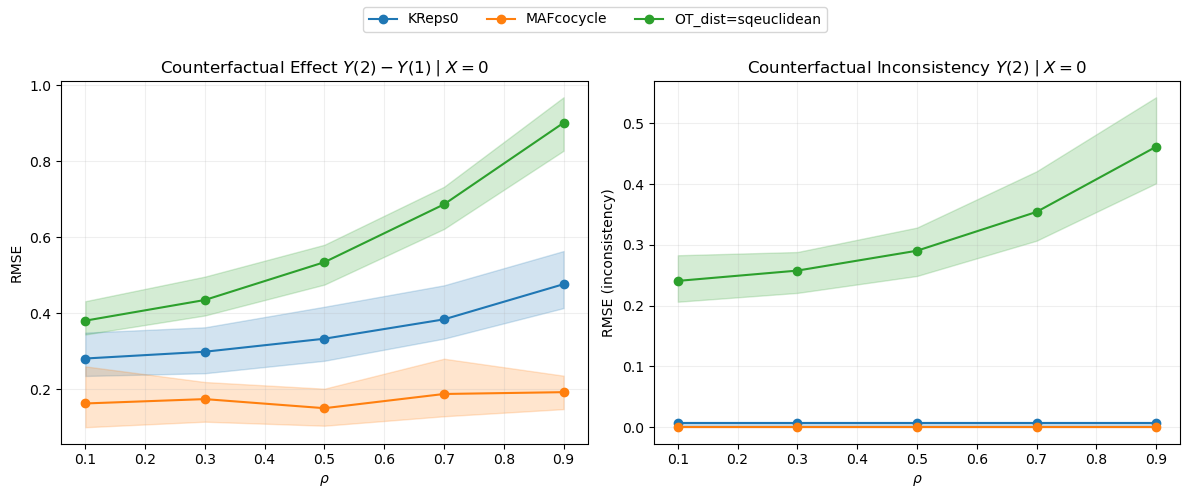

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_kr_sqeuclidean_cocycles(results,
                                 results_cocycle=None,
                                 use_median_iqr=True,
                                 alpha=0.05,
                                 trim_frac=0.0):
    """
    Plot KR OT, squared-Euclidean OT, and cocycle results.
    LHS: RMSE21direct
    RHS: RMSEinconsistency (cocycles plotted as zero).
    """
    # Base results: keep KR + sqeuclidean OT
    df_base = pd.DataFrame(results)
    mask_base = df_base['name'].str.contains('KReps|sqeuclidean', case=False, regex=True)
    df_base = df_base[mask_base].copy()

    # Append cocycles if provided
    if results_cocycle is not None:
        df_cocycle = pd.DataFrame(results_cocycle).copy()
        df_cocycle = df_cocycle.rename(columns={
            'ATE21': 'ATE21direct',
            'RMSE21': 'RMSE21direct'
        })
        # Add zero inconsistency
        df_cocycle['RMSEinconsistency'] = 0.0
        df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
    else:
        df_all = df_base.copy()

    df_all = df_all.sort_values('corr')

    # Trim helper
    if trim_frac > 0:
        def trim_group(g):
            g = g.copy()
            for col in ['RMSE21direct', 'RMSEinconsistency']:
                lo = g[col].quantile(trim_frac)
                hi = g[col].quantile(1 - trim_frac)
                g = g[(g[col] >= lo) & (g[col] <= hi)]
            return g
        df_all = (
            df_all.groupby(['name', 'corr'], group_keys=False)
                  .apply(trim_group)
                  .reset_index(drop=True)
        )

    # Aggregate
    grouped = df_all.groupby(['name', 'corr']).agg(
        RMSE_mean=('RMSE21direct', 'mean'),
        RMSE_std=('RMSE21direct', 'std'),
        RMSE_median=('RMSE21direct', 'median'),
        RMSE_q25=('RMSE21direct', lambda s: s.quantile(0.25)),
        RMSE_q75=('RMSE21direct', lambda s: s.quantile(0.75)),
        RMSE_qlo=('RMSE21direct', lambda s: s.quantile(alpha)),
        RMSE_qhi=('RMSE21direct', lambda s: s.quantile(1-alpha)),

        INC_mean=('RMSEinconsistency', 'mean'),
        INC_std=('RMSEinconsistency', 'std'),
        INC_median=('RMSEinconsistency', 'median'),
        INC_q25=('RMSEinconsistency', lambda s: s.quantile(0.25)),
        INC_q75=('RMSEinconsistency', lambda s: s.quantile(0.75)),
        INC_qlo=('RMSEinconsistency', lambda s: s.quantile(alpha)),
        INC_qhi=('RMSEinconsistency', lambda s: s.quantile(1-alpha)),
    ).reset_index()

    grouped[['RMSE_std', 'INC_std']] = grouped[['RMSE_std', 'INC_std']].fillna(0.0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    colors = {}

    if use_median_iqr:
        band_label = f'median ± IQR (trim {trim_frac*100:.0f}%)'
    elif alpha is not None:
        band_label = f'mean line, quantile band [{alpha:.2f},{1-alpha:.2f}] (trim {trim_frac*100:.0f}%)'
    else:
        band_label = f'mean ± std (trim {trim_frac*100:.0f}%)'

    for model in grouped['name'].unique():
        sub = grouped[grouped['name'] == model].sort_values('corr')
        x = sub['corr'].values

        # RMSE panel
        if use_median_iqr:
            y_line = sub['RMSE_median'].values
            y_lo = sub['RMSE_q25'].values
            y_hi = sub['RMSE_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_qlo'].values
            y_hi = sub['RMSE_qhi'].values
        else:
            y_line = sub['RMSE_mean'].values
            y_lo = y_line - sub['RMSE_std'].values
            y_hi = y_line + sub['RMSE_std'].values

        (l1,) = axes[0].plot(x, y_line, marker='o', label=model)
        if model not in colors:
            colors[model] = l1.get_color()
        c = colors[model]
        axes[0].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

        # Inconsistency panel
        if use_median_iqr:
            y_line = sub['INC_median'].values
            y_lo = sub['INC_q25'].values
            y_hi = sub['INC_q75'].values
        elif alpha is not None:
            y_line = sub['INC_mean'].values
            y_lo = sub['INC_qlo'].values
            y_hi = sub['INC_qhi'].values
        else:
            y_line = sub['INC_mean'].values
            y_lo = y_line - sub['INC_std'].values
            y_hi = y_line + sub['INC_std'].values

        axes[1].plot(x, y_line, marker='o', label=model, color=c)
        axes[1].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

    axes[0].set_title(r'Counterfactual Effect $Y(2) - Y(1) \mid  X=0$')
    axes[1].set_title(r'Counterfactual Inconsistency $Y(2) \mid  X=0$')
    for ax in axes:
        ax.set_xlabel(r'$\rho$')
        ax.grid(True, alpha=0.2)
    axes[0].set_ylabel('RMSE')
    axes[1].set_ylabel('RMSE (inconsistency)')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=min(5, len(labels)))
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()
    
results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=False_multivariate=False_dist=lap.pt')
results_cocycle = torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=False_lr=0.01_new.pt')
plot_kr_sqeuclidean_cocycles(results, results_cocycle, use_median_iqr=False, trim_frac=0.00)

/tmp/ipykernel_843769/1479593757.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_base = df_base['name'].str.contains(
/tmp/ipykernel_843769/1479593757.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(trim_group)


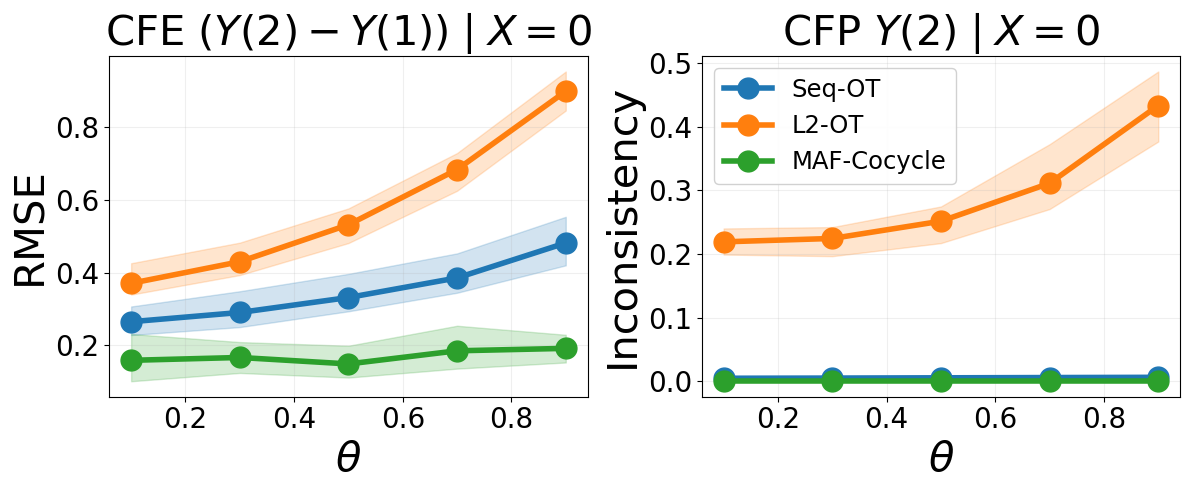

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_rmse_incons_trimmed_kr_sqeuclidean_cocycles(
        results, results_cocycle=None,
        use_median_iqr=True, alpha=0.05, trim_frac=0.05,
        # Legend + style controls (same API as your ATE/RMSE function)
        name_map=None,                 # e.g. {"KReps0":"KR (ours)", "OTsqeuclidean":"OT (L2)", "MAFcocycle":"MAF Cocycle"}
        legend_inside=False,           # place legend inside a subplot (True) or above figure (False)
        legend_ax_index=1,             # which subplot to put legend in if legend_inside=True (0 or 1)
        legend_loc='right',      # legend location if inside
        legend_ncol=None,              # legend column count (auto if None)
        # Font scaling
        base_fontsize=10,              # base fontsize
        title_scale=1.0, label_scale=1.0, tick_scale=1.0, legend_scale=1.0,
        # Regex patterns (adjust if your names differ)
        kr_pattern=r'KReps', sqeuclid_pattern=r'sqeuclidean',
        maf_cocycle_pattern=r'(maf.*cocycle|cocycle.*maf|mafcocycle)'
    ):
    """
    Plot ONLY:
      - KR results (name contains kr_pattern)
      - squared-Euclidean OT results (name contains sqeuclid_pattern)
      - cocycle results (appended; ATE21->ATE21direct, RMSE21->RMSE21direct, inconsistency=0)

    Panels: left=RMSE21direct, right=RMSEinconsistency
    Trimming: per (name, corr) & per metric by 'trim_frac' at both tails.
    Bands:
      - use_median_iqr=True         -> median line, 25–75% band
      - use_median_iqr=False, alpha -> mean line, [alpha, 1-alpha] band
      - use_median_iqr=False, None  -> mean line, ± std band
    """
    # --- Base: keep KR + squared-euclidean OT ---
    df_base = pd.DataFrame(results)
    mask_base = df_base['name'].str.contains(
        rf'({kr_pattern}|{sqeuclid_pattern})', flags=re.IGNORECASE, regex=True
    )
    df_base = df_base[mask_base].copy()

    # --- Append cocycle results (align names + set inconsistency=0) ---
    if results_cocycle is not None:
        if not isinstance(results_cocycle, list):
            results_cocycle = [results_cocycle]
        df_cocycle = pd.DataFrame(results_cocycle).copy()
        df_cocycle = df_cocycle.rename(columns={'ATE21': 'ATE21direct', 'RMSE21': 'RMSE21direct'})
        df_cocycle['RMSEinconsistency'] = 0.0
        df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
    else:
        df_all = df_base.copy()

    # Ensure columns exist
    for col in ['RMSE21direct', 'name', 'corr']:
        if col not in df_all.columns:
            raise KeyError(f"Missing required column '{col}' in combined results.")
    if 'RMSEinconsistency' not in df_all.columns:
        # Should exist for OT results; cocycle added above. If missing, fill NaN.
        df_all['RMSEinconsistency'] = np.nan

    df_all = df_all.sort_values('corr')

    # --- Trim per (name, corr) and per metric ---
    def trim_group(g):
        g = g.copy()
        for col in ['RMSE21direct', 'RMSEinconsistency']:
            lo = g[col].quantile(trim_frac)
            hi = g[col].quantile(1 - trim_frac)
            g = g[(g[col] >= lo) & (g[col] <= hi)]
        return g

    if trim_frac > 0:
        df_all = (
            df_all.groupby(['name', 'corr'], group_keys=False)
                  .apply(trim_group)
                  .reset_index(drop=True)
        )

    # --- Aggregate stats ---
    grouped = df_all.groupby(['name', 'corr']).agg(
        # RMSE
        RMSE_mean=('RMSE21direct', 'mean'),
        RMSE_std =('RMSE21direct', 'std'),
        RMSE_median=('RMSE21direct', 'median'),
        RMSE_q25=('RMSE21direct', lambda s: s.quantile(0.25)),
        RMSE_q75=('RMSE21direct', lambda s: s.quantile(0.75)),
        RMSE_qlo=('RMSE21direct', lambda s: s.quantile(alpha)),
        RMSE_qhi=('RMSE21direct', lambda s: s.quantile(1 - alpha)),
        # Inconsistency
        INC_mean=('RMSEinconsistency', 'mean'),
        INC_std =('RMSEinconsistency', 'std'),
        INC_median=('RMSEinconsistency', 'median'),
        INC_q25=('RMSEinconsistency', lambda s: s.quantile(0.25)),
        INC_q75=('RMSEinconsistency', lambda s: s.quantile(0.75)),
        INC_qlo=('RMSEinconsistency', lambda s: s.quantile(alpha)),
        INC_qhi=('RMSEinconsistency', lambda s: s.quantile(1 - alpha)),
    ).reset_index()

    grouped[['RMSE_std', 'INC_std']] = grouped[['RMSE_std', 'INC_std']].fillna(0.0)

    # --- Order models: put MAF cocycle last ---
    def is_maf_cocycle(name: str) -> bool:
        return bool(re.search(maf_cocycle_pattern, name, flags=re.IGNORECASE)) or 'cocycle' in name.lower()
    model_order = sorted(grouped['name'].unique(), key=lambda n: (is_maf_cocycle(n), n.lower()))

    # --- Font sizes ---
    plt.rcParams.update({
        'axes.titlesize': base_fontsize * title_scale,
        'axes.labelsize': base_fontsize * label_scale,
        'xtick.labelsize': base_fontsize * tick_scale,
        'ytick.labelsize': base_fontsize * tick_scale,
    })
    legend_fs = base_fontsize * legend_scale

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    colors = {}

    if use_median_iqr:
        band_label = f'median ± IQR (trim {trim_frac*100:.0f}%)'
    elif alpha is not None:
        band_label = f'mean line, quantile band [{alpha:.2f}, {1-alpha:.2f}] (trim {trim_frac*100:.0f}%)'
    else:
        band_label = f'mean ± std (trim {trim_frac*100:.0f}%)'

    for model in model_order:
        sub = grouped[grouped['name'] == model].sort_values('corr')
        if sub.empty:
            continue
        x = sub['corr'].values

        # ----- Left: RMSE -----
        if use_median_iqr:
            y_line = sub['RMSE_median'].values
            y_lo = sub['RMSE_q25'].values
            y_hi = sub['RMSE_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE_mean'].values
            y_lo = sub['RMSE_qlo'].values
            y_hi = sub['RMSE_qhi'].values
        else:
            y_line = sub['RMSE_mean'].values
            y_lo = y_line - sub['RMSE_std'].values
            y_hi = y_line + sub['RMSE_std'].values

        disp_label = name_map.get(model, model) if name_map else model
        (l1,) = axes[0].plot(x, y_line, marker='o', label=disp_label, markersize = 15, lw = 4)
        if model not in colors:
            colors[model] = l1.get_color()
        c = colors[model]
        axes[0].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

        # ----- Right: Inconsistency -----
        if use_median_iqr:
            y_line = sub['INC_median'].values
            y_lo = sub['INC_q25'].values
            y_hi = sub['INC_q75'].values
        elif alpha is not None:
            y_line = sub['INC_mean'].values
            y_lo = sub['INC_qlo'].values
            y_hi = sub['INC_qhi'].values
        else:
            y_line = sub['INC_mean'].values
            y_lo = y_line - sub['INC_std'].values
            y_hi = y_line + sub['INC_std'].values

        axes[1].plot(x, y_line, marker='o', label=disp_label, color=c, markersize = 15, lw = 4)
        axes[1].fill_between(x, y_lo, y_hi, alpha=0.2, color=c)

    # --- Titles / labels (EXACT as you set) ---
    axes[0].set_title(r'CFE $(Y(2) - Y(1)) \mid  X=0$')
    axes[1].set_title(r'CFP $Y(2) \mid  X=0$')
    for ax in axes:
        ax.set_xlabel(r'$\theta$')
        ax.grid(True, alpha=0.2)
    axes[0].set_ylabel('RMSE')
    axes[1].set_ylabel('Inconsistency')

    # --- Legend: inside a subplot or above figure ---
    if legend_inside:
        axL = axes[legend_ax_index]
        handles, labels = axL.get_legend_handles_labels()
        if legend_ncol is None:
            legend_ncol = min(6, len(labels))
        axL.legend(handles, labels, loc="best", fontsize=legend_fs,
                   framealpha=0.9, ncol=legend_ncol)
    else:
        handles, labels = axes[0].get_legend_handles_labels()
        if legend_ncol is None:
            legend_ncol = min(6, len(labels))
        fig.legend(handles, labels, loc='upper center', ncol=legend_ncol, fontsize=legend_fs)

    plt.tight_layout(rect=[0, 0, 1, 0.90] if not legend_inside else None)
    plt.savefig("OT_results_consistency_effect.png", bbox_inches = "tight")
    plt.show()
    
# Example:
results =  torch.load('OT_affine_results_trials=20_n=500_m=500_additive=False_multivariate=False_dist=laplace.pt')
results_cocycle = torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=False_lr=0.01_new.pt')
name_map = {
    'KReps0': 'Seq-OT',
    'OT_dist=sqeuclidean': 'L2-OT',
    'MAFcocycle': 'MAF-Cocycle',
}
plot_rmse_incons_trimmed_kr_sqeuclidean_cocycles(results, results_cocycle, use_median_iqr=False, trim_frac = 0.01, legend_inside = True,
                                                   title_scale=3.0, label_scale=3.0, tick_scale=2.0, legend_scale=1.75, name_map = name_map,
                                                   legend_ncol = 1)

/tmp/ipykernel_644654/732519498.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_base = df_base['name'].str.contains(r'(KReps|sqeuclidean)', flags=re.IGNORECASE, regex=True)
/tmp/ipykernel_644654/732519498.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_vars, group_keys=False).apply(trim_group).reset_index(drop=True)
/tmp/ipykernel_644654/732519498.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_gro

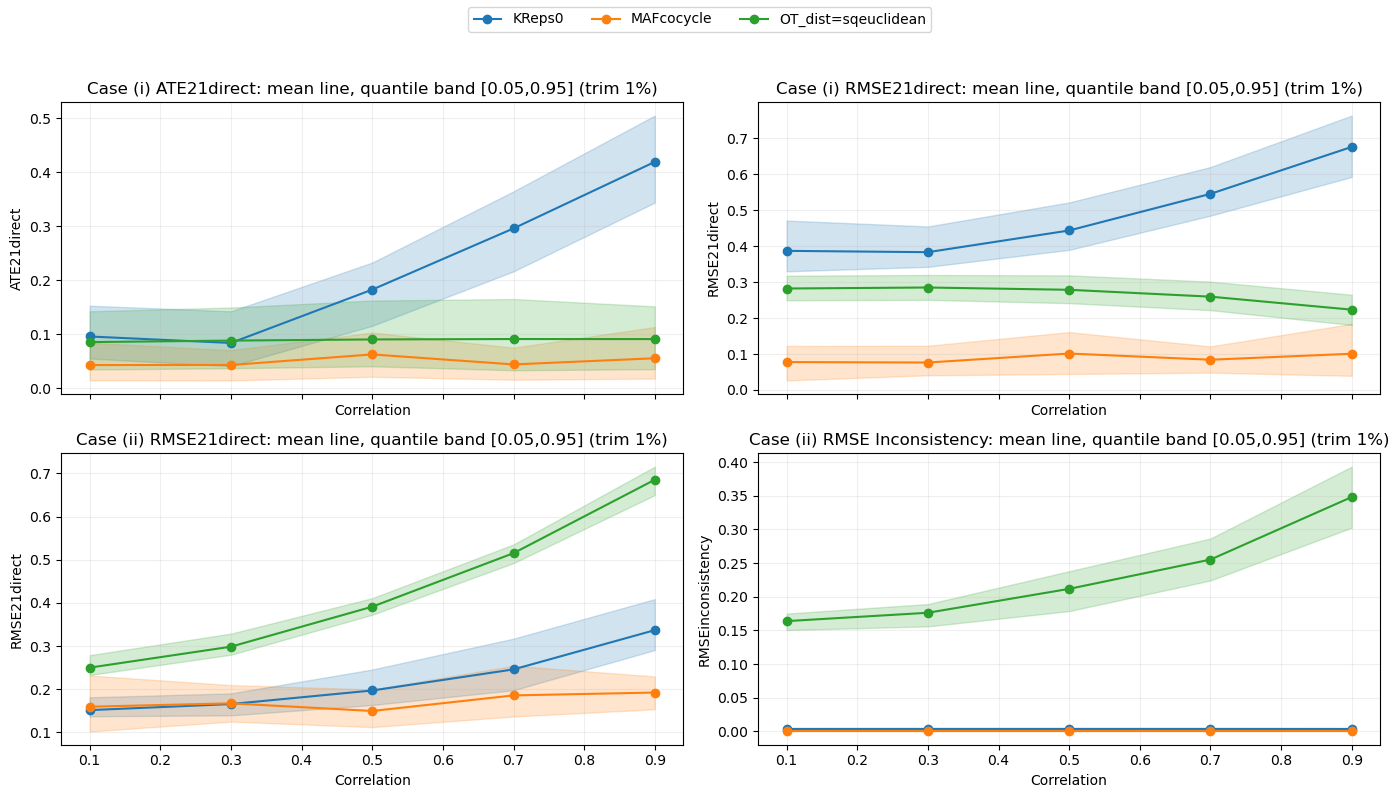

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re

def plot_case_i_and_ii(results_i, results_cocycle_i,
                       results_ii, results_cocycle_ii,
                       use_median_iqr=True, alpha=0.05, trim_frac=0.0):
    """
    Combined 4-panel plot:
      Top row = Case (i): [ATE21direct, RMSE21direct]
      Bottom row = Case (ii): [RMSE21direct, RMSE Inconsistency]

    Case (i): uses ATE/RMSE logic from plot_ate_rmse_bands_trimmed_kr_sqeuclidean_cocycles
    Case (ii): uses RMSE/Inconsistency logic from plot_kr_sqeuclidean_cocycles
    """

    def prepare_case_i_df(results, results_cocycle):
        df_base = pd.DataFrame(results)
        mask_base = df_base['name'].str.contains(r'(KReps|sqeuclidean)', flags=re.IGNORECASE, regex=True)
        df_base = df_base[mask_base].copy()

        if results_cocycle is not None:
            if not isinstance(results_cocycle, list):
                results_cocycle = [results_cocycle]
            df_cocycle = pd.DataFrame(results_cocycle).copy()
            df_cocycle = df_cocycle.rename(columns={'ATE21': 'ATE21direct', 'RMSE21': 'RMSE21direct'})
            df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
        else:
            df_all = df_base.copy()

        return df_all.sort_values('corr')

    def prepare_case_ii_df(results, results_cocycle):
        df_base = pd.DataFrame(results)
        mask_base = df_base['name'].str.contains('KReps|sqeuclidean', case=False, regex=True)
        df_base = df_base[mask_base].copy()

        if results_cocycle is not None:
            df_cocycle = pd.DataFrame(results_cocycle).copy()
            df_cocycle = df_cocycle.rename(columns={
                'ATE21': 'ATE21direct',
                'RMSE21': 'RMSE21direct'
            })
            df_cocycle['RMSEinconsistency'] = 0.0
            df_all = pd.concat([df_base, df_cocycle], ignore_index=True)
        else:
            df_all = df_base.copy()

        return df_all.sort_values('corr')

    def trim_and_group(df, metric_cols, group_vars):
        if trim_frac > 0:
            def trim_group(g):
                g = g.copy()
                for col in metric_cols:
                    lo = g[col].quantile(trim_frac)
                    hi = g[col].quantile(1 - trim_frac)
                    g = g[(g[col] >= lo) & (g[col] <= hi)]
                return g
            df = df.groupby(group_vars, group_keys=False).apply(trim_group).reset_index(drop=True)

        agg_dict = {}
        for col in metric_cols:
            agg_dict[col+'_mean'] = (col, 'mean')
            agg_dict[col+'_std'] = (col, 'std')
            agg_dict[col+'_median'] = (col, 'median')
            agg_dict[col+'_q25'] = (col, lambda s: s.quantile(0.25))
            agg_dict[col+'_q75'] = (col, lambda s: s.quantile(0.75))
            agg_dict[col+'_qlo'] = (col, lambda s: s.quantile(alpha))
            agg_dict[col+'_qhi'] = (col, lambda s: s.quantile(1-alpha))

        grouped = df.groupby(group_vars).agg(**agg_dict).reset_index()
        for col in metric_cols:
            grouped[col+'_std'] = grouped[col+'_std'].fillna(0.0)
        return grouped

    # ---- Prepare and aggregate ----
    df_i = prepare_case_i_df(results_i, results_cocycle_i)
    g_i = trim_and_group(df_i, ['ATE21direct', 'RMSE21direct'], ['name', 'corr'])

    df_ii = prepare_case_ii_df(results_ii, results_cocycle_ii)
    g_ii = trim_and_group(df_ii, ['RMSE21direct', 'RMSEinconsistency'], ['name', 'corr'])

    # ---- Plot ----
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='col')
    colors = {}
    if use_median_iqr:
        band_label = f'median ± IQR (trim {trim_frac*100:.0f}%)'
    elif alpha is not None:
        band_label = f'mean line, quantile band [{alpha:.2f},{1-alpha:.2f}] (trim {trim_frac*100:.0f}%)'
    else:
        band_label = f'mean ± std (trim {trim_frac*100:.0f}%)'

    # --- Case (i) ---
    for model in g_i['name'].unique():
        sub = g_i[g_i['name'] == model].sort_values('corr')
        x = sub['corr'].values
        if use_median_iqr:
            y_line = sub['ATE21direct_median'].values
            y_lo = sub['ATE21direct_q25'].values
            y_hi = sub['ATE21direct_q75'].values
        elif alpha is not None:
            y_line = sub['ATE21direct_mean'].values
            y_lo = sub['ATE21direct_qlo'].values
            y_hi = sub['ATE21direct_qhi'].values
        else:
            y_line = sub['ATE21direct_mean'].values
            y_lo = y_line - sub['ATE21direct_std'].values
            y_hi = y_line + sub['ATE21direct_std'].values
        (l1,) = axes[0,0].plot(x, y_line, marker='o', label=model)
        if model not in colors: colors[model] = l1.get_color()
        axes[0,0].fill_between(x, y_lo, y_hi, alpha=0.2, color=colors[model])

        if use_median_iqr:
            y_line = sub['RMSE21direct_median'].values
            y_lo = sub['RMSE21direct_q25'].values
            y_hi = sub['RMSE21direct_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE21direct_mean'].values
            y_lo = sub['RMSE21direct_qlo'].values
            y_hi = sub['RMSE21direct_qhi'].values
        else:
            y_line = sub['RMSE21direct_mean'].values
            y_lo = y_line - sub['RMSE21direct_std'].values
            y_hi = y_line + sub['RMSE21direct_std'].values
        axes[0,1].plot(x, y_line, marker='o', label=model, color=colors[model])
        axes[0,1].fill_between(x, y_lo, y_hi, alpha=0.2, color=colors[model])

    # --- Case (ii) ---
    for model in g_ii['name'].unique():
        sub = g_ii[g_ii['name'] == model].sort_values('corr')
        x = sub['corr'].values
        if use_median_iqr:
            y_line = sub['RMSE21direct_median'].values
            y_lo = sub['RMSE21direct_q25'].values
            y_hi = sub['RMSE21direct_q75'].values
        elif alpha is not None:
            y_line = sub['RMSE21direct_mean'].values
            y_lo = sub['RMSE21direct_qlo'].values
            y_hi = sub['RMSE21direct_qhi'].values
        else:
            y_line = sub['RMSE21direct_mean'].values
            y_lo = y_line - sub['RMSE21direct_std'].values
            y_hi = y_line + sub['RMSE21direct_std'].values
        axes[1,0].plot(x, y_line, marker='o', label=model, color=colors.get(model, None))
        axes[1,0].fill_between(x, y_lo, y_hi, alpha=0.2, color=colors.get(model, None))

        if use_median_iqr:
            y_line = sub['RMSEinconsistency_median'].values
            y_lo = sub['RMSEinconsistency_q25'].values
            y_hi = sub['RMSEinconsistency_q75'].values
        elif alpha is not None:
            y_line = sub['RMSEinconsistency_mean'].values
            y_lo = sub['RMSEinconsistency_qlo'].values
            y_hi = sub['RMSEinconsistency_qhi'].values
        else:
            y_line = sub['RMSEinconsistency_mean'].values
            y_lo = y_line - sub['RMSEinconsistency_std'].values
            y_hi = y_line + sub['RMSEinconsistency_std'].values
        axes[1,1].plot(x, y_line, marker='o', label=model, color=colors.get(model, None))
        axes[1,1].fill_between(x, y_lo, y_hi, alpha=0.2, color=colors.get(model, None))

    # Titles / labels
    axes[0,0].set_title(f'Case (i) ATE21direct: {band_label}')
    axes[0,1].set_title(f'Case (i) RMSE21direct: {band_label}')
    axes[1,0].set_title(f'Case (ii) RMSE21direct: {band_label}')
    axes[1,1].set_title(f'Case (ii) RMSE Inconsistency: {band_label}')
    for ax in axes.flat:
        ax.set_xlabel('Correlation')
        ax.grid(True, alpha=0.2)
    axes[0,0].set_ylabel('ATE21direct')
    axes[0,1].set_ylabel('RMSE21direct')
    axes[1,0].set_ylabel('RMSE21direct')
    axes[1,1].set_ylabel('RMSEinconsistency')

    # Legend
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=min(6, len(labels)))
    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

plot_case_i_and_ii(
    torch.load('OT_affine_results_trials=20_n=500_m=500_additive=True_multivariate=True.pt'),
    torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=True_lr=0.01_new.pt'),
    torch.load('OT_affine_results_trials=20_n=500_m=500_additive=False_multivariate=False.pt'),
    torch.load('nfcocycle_cv_results_trials=20_n=500_corr=0.9_affine=True_additive=False_lr=0.01_new.pt'),
    use_median_iqr=False, trim_frac=0.01
)